In [1]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# **ACB**

In [2]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test theo tỉ lệ 8.5:1.5
df = pd.read_csv('DATASET/ACB Historical Data.csv')


In [3]:
# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df["Change %"] = df["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'] = df['Price'].apply(convert_str_to_number)
df['Open'] = df['Open'].apply(convert_str_to_number)
df['High'] = df['High'].apply(convert_str_to_number)
df['Low'] = df['Low'].apply(convert_str_to_number)

In [4]:
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.85 * len(df))
test_size = int(0.15 * len(df))

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

In [5]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=18885.808, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18883.329, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18884.946, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18884.969, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18882.493, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=18881.815, Time=0.41 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=18883.667, Time=0.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=18883.982, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=18885.757, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=18885.591, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=18881.016, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=18884.175, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=18884.154, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=18882.836, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [6]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

In [7]:
# 5. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[25244.36889774 25202.26638973 25242.21827655 25204.30715592
 25240.28175392 25206.14475982 25238.53801592 25207.79942664
 25236.96787046 25209.28936813 25235.55403607 25210.63098302
 25234.28095167 25211.83903751 25233.13460533 25212.9268278
 25232.10238001 25213.90632643 25231.17291475 25214.78831405
 25230.33597958 25215.58249807 25229.58236296 25216.29761951
 25228.90377035 25216.94154921 25228.29273296 25217.52137444
 25227.74252555 25218.04347693]


In [8]:
# 6. Đánh giá độ chính xác test

test_ape = np.abs((y_test - y_pred) / y_test)
test_mape = np.mean(test_ape) * 100
print('MAPE: ', test_mape)

test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
print('RMSE: ', test_rmse)

# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

test_mda = calculate_mda(y_test, y_pred)
print('MDA: ', test_mda)

MAPE:  9.324031262690562
RMSE:  2438.2273407650428
MDA:  49.77777777777778


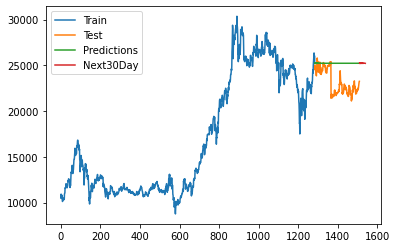

In [9]:
# 7.Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()

# **PVS**

In [10]:
# Đọc file dữ liệu chứng khoán AAPL và chia train test theo tỉ lệ 8.5:1.5
df = pd.read_csv('DATASET/PVS Historical Data.csv')

In [11]:
# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df["Change %"] = df["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'] = df['Price'].apply(convert_str_to_number)
df['Open'] = df['Open'].apply(convert_str_to_number)
df['High'] = df['High'].apply(convert_str_to_number)
df['Low'] = df['Low'].apply(convert_str_to_number)


In [12]:
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.85 * len(df))
test_size = int(0.15 * len(df))

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]


In [13]:
# Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=20586.320, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20583.993, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20585.973, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=20585.974, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20582.097, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=20582.944, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.668 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [15]:
# Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))


In [16]:
# Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)


Predicted closing prices for the next 30 days:
[25600. 25600. 25600. 25600. 25600. 25600. 25600. 25600. 25600. 25600.
 25600. 25600. 25600. 25600. 25600. 25600. 25600. 25600. 25600. 25600.
 25600. 25600. 25600. 25600. 25600. 25600. 25600. 25600. 25600. 25600.]


In [17]:
# Đánh giá độ chính xác test

test_ape = np.abs((y_test - y_pred) / y_test)
test_mape = np.mean(test_ape) * 100
print('MAPE: ', test_mape)

test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
print('RMSE: ', test_rmse)

# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

test_mda = calculate_mda(y_test, y_pred)
print('MDA: ', test_mda)

MAPE:  19.17061569972454
RMSE:  8311.350447159992
MDA:  8.849557522123893


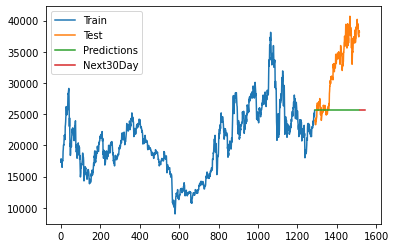

In [18]:
# Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()


# **VNM**

In [19]:
# Đọc file dữ liệu chứng khoán AAPL và chia train test theo tỉ lệ 8.5:1.5
df = pd.read_csv('DATASET/VNM Historical Data.csv')

In [20]:
# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df["Change %"] = df["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'] = df['Price'].apply(convert_str_to_number)
df['Open'] = df['Open'].apply(convert_str_to_number)
df['High'] = df['High'].apply(convert_str_to_number)
df['Low'] = df['Low'].apply(convert_str_to_number)

In [21]:
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.85 * len(df))
test_size = int(0.15 * len(df))

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

In [22]:
# Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=22978.785, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22998.258, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22993.278, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22993.161, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=22997.768, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=22990.475, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=22989.639, Time=0.35 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=22980.390, Time=0.64 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=22980.957, Time=0.46 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22994.315, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=22988.077, Time=0.45 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=22985.367, Time=0.42 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=22982.424, Time=0.52 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=22977.320, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [23]:
# Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

In [24]:
# Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[77093.72298996 77220.0461386  77354.64613807 77418.3344249
 77403.61554606 77350.19409222 77303.68651032 77287.53930599
 77298.69305159 77319.92448055 77335.2287516  77338.35320167
 77332.41548637 77324.39269832 77319.6424483  77319.5315348
 77322.26409396 77325.16078744 77326.52302154 77326.19757464
 77325.04393548 77324.04415257 77323.70016627 77323.943186
 77324.40108544 77324.72967518 77324.79552919 77324.66677042
 77324.49393559 77324.39210611]


In [25]:
# Đánh giá độ chính xác test

test_ape = np.abs((y_test - y_pred) / y_test)
test_mape = np.mean(test_ape) * 100
print('MAPE: ', test_mape)

test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
print('RMSE: ', test_rmse)

# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

test_mda = calculate_mda(y_test, y_pred)
print('MDA: ', test_mda)

MAPE:  7.317548070804316
RMSE:  6135.518155807256
MDA:  24.778761061946902


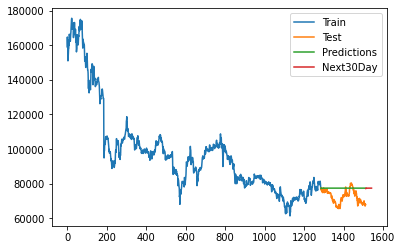

In [26]:
# Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()